In [1]:
import mesh_renderer
import os

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.animation as animation



import camera_utils
import rasterize_triangles

from IPython.display import Image
import PIL
from stl import mesh

from io import BytesIO
def drawarray(a, fmt="png"):
    a = np.uint8(a)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    return Image(data=f.getvalue())

In [93]:
def drawarrays(arrays):
    ratio = arrays[0].shape[1] / arrays[0].shape[0]
    fig, ax = plt.subplots(figsize=(5, 5 * ratio))
    im = ax.imshow(arrays[0])
    def update(i):
        im.set_data(arrays[i])
    plt.axis('off')
    ani = animation.FuncAnimation(fig, update, frames=np.arange(0, len(arrays)), interval=50)
    plt.close()
    return ani
    
def get_triangles(bust):
    indices = {}
    indices_list = []
    triangles = []
    for tri in bust.vectors:
        triangle = []
        for idx, v in enumerate(tri):
            val = tuple(v)
            if val not in indices:
                index = len(indices)
                indices_list.append(val)
                indices[val] = index
            else:
                index = indices[val]
            triangle.append(index)
        triangles.append(triangle)
    return indices_list, triangles
            

In [312]:
bust = mesh.Mesh.from_file("/home/jonathanraiman/Coding/tf_mesh_renderer/data/Slic3r_friendly_pt5_scale_tilted.stl")
vertices, triangles = get_triangles(bust)
triangles = np.array(triangles)
vertices = np.array(vertices)
vertices -= vertices.mean(axis=0, keepdims=True)
vertices = (vertices / np.array(vertices).max()) * 2

cube_vertices = np.array([[-1, -1, 1], [-1, -1, -1], [-1, 1, -1], [-1, 1, 1], [1, -1, 1],
         [1, -1, -1], [1, 1, -1], [1, 1, 1]])
cube_triangles = np.array([[0, 1, 2], [2, 3, 0], [3, 2, 6], [6, 7, 3], [7, 6, 5], [5, 4, 7],
         [4, 5, 1], [1, 0, 4], [5, 6, 2], [2, 1, 5], [7, 4, 0], [0, 3, 7]], dtype=np.int32)


In [363]:
tf.map_fn??

In [465]:
def render_cube(*, vertices, normals, triangles, angles, image_height=300, image_width=300):
    model_rotation = camera_utils.euler_matrices(angles)[0, :3, :3]
    vertices_world_space = tf.reshape(
        tf.matmul(vertices, model_rotation, transpose_b=True),
        [1, vertices.get_shape()[0].value, 3])
    # camera position:
    eye = tf.constant([[0.0, 0.0, 6.0]], dtype=tf.float32)
    center = tf.constant([[0.0, 0.0, 0.0]], dtype=tf.float32)
    world_up = tf.constant([[0.0, 1.0, 0.0]], dtype=tf.float32)

    vertex_diffuse_colors = tf.ones_like(vertices_world_space, dtype=tf.float32)
    light_positions = tf.reshape(eye, [1, 1, 3])
    light_intensities = tf.ones([1, 1, 3], dtype=tf.float32)
    
    vertex_positions = tf.reshape(
        tf.matmul(vertices, model_rotation, transpose_b=True),
        [1, vertices.get_shape()[0].value, 3])
    desired_normals = tf.reshape(
        tf.matmul(normals, model_rotation, transpose_b=True),
        [1, vertices.get_shape()[0].value, 3])
    render = mesh_renderer.mesh_renderer(
        vertex_positions, triangles, desired_normals,
        vertex_diffuse_colors, eye, center, world_up, light_positions,
        light_intensities, image_width, image_height)
    return tf.reshape(render, [image_height, image_width, 4])


def build_nodes(*, object_vertices, object_triangles,
                image_height=300, image_width=300):
    object_vertices = tf.constant(object_vertices, dtype=tf.float32)
    object_normals = tf.nn.l2_normalize(object_vertices, dim=1)
    target_angles = tf.placeholder(tf.float32, shape=[None, 3])
    starting_angles = tf.placeholder(tf.float32, shape=[None, 3])
    training = tf.placeholder_with_default(False, shape=())
    desired_render = tf.map_fn(lambda x: render_cube(vertices=object_vertices,
                                                     normals=object_normals,
                                                     triangles=object_triangles,
                                                     angles=x[None, :],
                                                     image_height=image_height,
                                                     image_width=image_width),
                               target_angles)
    starting_render = tf.map_fn(lambda x: render_cube(vertices=object_vertices,
                                                      normals=object_normals,
                                                      triangles=object_triangles,
                                                      angles=x[None, :],
                                                      image_height=image_height,
                                                      image_width=image_width),
                                starting_angles)
    
    # by observing the rendered image, predict how to change the state
    # of the world to make things better
    sizes = [
        (128, 5),
        (128, 5),
        (128, 5),
    ]
    out = tf.concat([desired_render[:, :, :, :3]], axis=-1)
    for filters, kernel_size in sizes:
        out = tf.nn.leaky_relu(tf.contrib.layers.batch_norm(
            tf.layers.conv2d(out, filters, kernel_size, strides=(2, 2),
                               activation=None,
                               kernel_initializer=tf.random_uniform_initializer(-0.002, 0.002),
                               bias_initializer=tf.zeros_initializer()),
            is_training=training))
    predicted_angles = tf.contrib.layers.fully_connected(
        tf.reshape(out, [tf.shape(out)[0], out.get_shape()[1].value * out.get_shape()[2].value * out.get_shape()[3].value]), 3,
        activation_fn=None,
        biases_initializer=tf.zeros_initializer(),
        weights_initializer=tf.random_uniform_initializer(-0.002, 0.002))
    render = tf.map_fn(lambda x: render_cube(vertices=object_vertices,
                                             normals=object_normals,
                                             triangles=object_triangles,
                                             angles=x[None, :],
                                             image_height=image_height,
                                             image_width=image_width), predicted_angles)
    
    
    #  + starting_angles
    loss = tf.reduce_mean(tf.abs(render - desired_render))
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)
    vars = tf.trainable_variables()
    grads = tf.gradients(loss, vars)
    grads, _ = tf.clip_by_global_norm(grads, 1.0)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_op = optimizer.apply_gradients(zip(grads, vars))
    return {
        "loss": loss,
        "train_op": train_op,
        "render": render,
        "desired_render": desired_render,
        "predicted_angles": predicted_angles,
        "target_angles": target_angles,
        "starting_angles": starting_angles,
        "training": training,
    }



In [466]:
tf.reset_default_graph()

In [467]:
errors = []
scales = []
sess = tf.InteractiveSession()
nodes = build_nodes(object_triangles=triangles, object_vertices=vertices,
                   image_height=300, image_width=300)
sess.run(tf.global_variables_initializer())
noise_level = 10.0
ema_l = None
batch_size = 8
time_without_improvement = 0
for i in range(1000):
    target = np.array([[0.0, 0.0, 0.0] for _ in range(batch_size)])
    l, _ = sess.run([nodes["loss"], nodes["train_op"]],
                    {nodes["target_angles"]: target + np.random.uniform(-noise_level, noise_level, size=(batch_size, 3)),
                     nodes["training"]: True})
    print("{} Loss {}, imp={}".format(i, l, time_without_improvement))
    errors.append(l)
    scales.append(noise_level)
    if ema_l is None:
        ema_l = l
    else:
        ema_l = ema_l * 0.99 + 0.01 * l
    if ema_l < 0.01 or time_without_improvement > 150:
        if noise_level >= 30:
            break
        print("Increasing noise level {}".format(noise_level))
        ema_l = None
        noise_level *= 1.1
        time_without_improvement = 0
    else:
        time_without_improvement += 1
        

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'map/while/assert_greater/Assert/AssertGuard/Merge' type=Merge>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/lib64/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/usr/lib64/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/usr/local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/usr/local/lib64/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()  File "/usr/

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'map_1/while/assert_greater/Assert/AssertGuard/Merge' type=Merge>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/lib64/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/usr/lib64/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/usr/local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/usr/local/lib64/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()  File "/us

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'map_2/while/assert_greater/Assert/AssertGuard/Merge' type=Merge>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/lib64/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/usr/lib64/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/usr/local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/usr/local/lib64/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()  File "/us

0 Loss 0.13156495988368988, imp=0
1 Loss 0.1430773288011551, imp=1
2 Loss 0.15063072741031647, imp=2
3 Loss 0.13638685643672943, imp=3
4 Loss 0.1332218497991562, imp=4
5 Loss 0.13810105621814728, imp=5
6 Loss 0.12907201051712036, imp=6
7 Loss 0.14942823350429535, imp=7
8 Loss 0.14159424602985382, imp=8
9 Loss 0.15487611293792725, imp=9
10 Loss 0.14892318844795227, imp=10
11 Loss 0.15298143029212952, imp=11
12 Loss 0.14944209158420563, imp=12
13 Loss 0.14720658957958221, imp=13
14 Loss 0.1209753006696701, imp=14
15 Loss 0.1609436720609665, imp=15
16 Loss 0.1297174096107483, imp=16
17 Loss 0.1433413028717041, imp=17
18 Loss 0.1572398692369461, imp=18
19 Loss 0.12449492514133453, imp=19
20 Loss 0.14066755771636963, imp=20
21 Loss 0.15479111671447754, imp=21
22 Loss 0.15148846805095673, imp=22
23 Loss 0.15679876506328583, imp=23
24 Loss 0.15885569155216217, imp=24
25 Loss 0.1528327316045761, imp=25
26 Loss 0.14087142050266266, imp=26
27 Loss 0.13211002945899963, imp=27
28 Loss 0.1592568904

226 Loss 0.11482803523540497, imp=74
227 Loss 0.1619085967540741, imp=75
228 Loss 0.15704238414764404, imp=76
229 Loss 0.12311583012342453, imp=77
230 Loss 0.1491003781557083, imp=78
231 Loss 0.1371704787015915, imp=79
232 Loss 0.11438547074794769, imp=80
233 Loss 0.13960051536560059, imp=81
234 Loss 0.14723043143749237, imp=82
235 Loss 0.13347476720809937, imp=83
236 Loss 0.13875994086265564, imp=84
237 Loss 0.1405775398015976, imp=85
238 Loss 0.1439201682806015, imp=86
239 Loss 0.17231743037700653, imp=87
240 Loss 0.17950524389743805, imp=88
241 Loss 0.12792633473873138, imp=89
242 Loss 0.12741628289222717, imp=90
243 Loss 0.15162597596645355, imp=91
244 Loss 0.1323959231376648, imp=92
245 Loss 0.13895076513290405, imp=93
246 Loss 0.14438478648662567, imp=94
247 Loss 0.13944032788276672, imp=95
248 Loss 0.1301725059747696, imp=96
249 Loss 0.1461961567401886, imp=97
250 Loss 0.13550274074077606, imp=98
251 Loss 0.14964236319065094, imp=99
252 Loss 0.13086621463298798, imp=100
253 Loss

448 Loss 0.1328505277633667, imp=144
449 Loss 0.16672255098819733, imp=145
450 Loss 0.14869123697280884, imp=146
451 Loss 0.1437734216451645, imp=147
452 Loss 0.13429652154445648, imp=148
453 Loss 0.15189838409423828, imp=149
454 Loss 0.1288227140903473, imp=150
455 Loss 0.1565253734588623, imp=151
Increasing noise level 12.100000000000001
456 Loss 0.17782004177570343, imp=0
457 Loss 0.13993072509765625, imp=1
458 Loss 0.1336131989955902, imp=2
459 Loss 0.14403152465820312, imp=3
460 Loss 0.17118820548057556, imp=4
461 Loss 0.15404516458511353, imp=5
462 Loss 0.13388954102993011, imp=6
463 Loss 0.12301896512508392, imp=7
464 Loss 0.13407228887081146, imp=8
465 Loss 0.14856885373592377, imp=9
466 Loss 0.1554938554763794, imp=10
467 Loss 0.1476503312587738, imp=11
468 Loss 0.13065838813781738, imp=12
469 Loss 0.140415221452713, imp=13
470 Loss 0.16671869158744812, imp=14
471 Loss 0.14549140632152557, imp=15
472 Loss 0.14835596084594727, imp=16
473 Loss 0.13483701646327972, imp=17
474 Los

668 Loss 0.1372305303812027, imp=60
669 Loss 0.16915704309940338, imp=61
670 Loss 0.14467459917068481, imp=62
671 Loss 0.14443862438201904, imp=63
672 Loss 0.1622350513935089, imp=64
673 Loss 0.1554267555475235, imp=65
674 Loss 0.1448219120502472, imp=66
675 Loss 0.14671234786510468, imp=67
676 Loss 0.14299866557121277, imp=68
677 Loss 0.12866859138011932, imp=69
678 Loss 0.1704183667898178, imp=70
679 Loss 0.12975704669952393, imp=71
680 Loss 0.15736980736255646, imp=72
681 Loss 0.1386987268924713, imp=73
682 Loss 0.15374700725078583, imp=74
683 Loss 0.14558923244476318, imp=75
684 Loss 0.14081604778766632, imp=76
685 Loss 0.16526207327842712, imp=77
686 Loss 0.1530039757490158, imp=78
687 Loss 0.13067366182804108, imp=79
688 Loss 0.14595991373062134, imp=80
689 Loss 0.1566282957792282, imp=81
690 Loss 0.17242363095283508, imp=82
691 Loss 0.13915088772773743, imp=83
692 Loss 0.15251626074314117, imp=84
693 Loss 0.13610662519931793, imp=85
694 Loss 0.15066854655742645, imp=86
695 Loss 

889 Loss 0.13989758491516113, imp=129
890 Loss 0.1441713571548462, imp=130
891 Loss 0.11675475537776947, imp=131
892 Loss 0.15728358924388885, imp=132
893 Loss 0.1361638456583023, imp=133
894 Loss 0.1437271535396576, imp=134
895 Loss 0.136481374502182, imp=135
896 Loss 0.14325477182865143, imp=136
897 Loss 0.13448402285575867, imp=137
898 Loss 0.16645567119121552, imp=138
899 Loss 0.12162644416093826, imp=139
900 Loss 0.1407281756401062, imp=140
901 Loss 0.13836239278316498, imp=141
902 Loss 0.14112311601638794, imp=142
903 Loss 0.12765249609947205, imp=143
904 Loss 0.13114680349826813, imp=144
905 Loss 0.1570621281862259, imp=145
906 Loss 0.14474672079086304, imp=146
907 Loss 0.1234152764081955, imp=147
908 Loss 0.14247269928455353, imp=148
909 Loss 0.18503053486347198, imp=149
910 Loss 0.1494409292936325, imp=150
911 Loss 0.1300601065158844, imp=151
Increasing noise level 16.105100000000004
912 Loss 0.11655845493078232, imp=0
913 Loss 0.15268221497535706, imp=1
914 Loss 0.13589903712

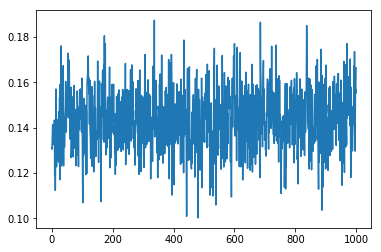

In [461]:
plt.plot(errors)
#plt.plot(scales)

In [438]:
l, pred = sess.run([nodes["loss"], nodes["predicted_angles"]], {nodes["target_angles"]: [[20.0, 0.0, 60.0]]})
print(pred)

[[0.00257867 0.0094438  0.00926618]]


In [451]:
renders = []
for i in range(400):
    l, pred, temp = sess.run([nodes["loss"], nodes["predicted_angles"], nodes["render"]],
                              {nodes["target_angles"]: [[0.05, 0.01, 0.01]]})
    renders.append(temp[0])
    print(l)
    break

0.015686348


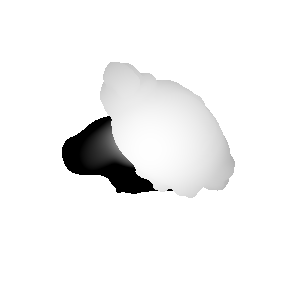

In [441]:
drawarray(renders[-1] * 255)

In [430]:
HTML(drawarrays(renders).to_html5_video())